In [1]:
TRAINING_MODEL_PATH = "microsoft/deberta-v3-base"

import json

data = json.load(open("data/train.json"))

print(len(data))
print(data[0].keys())

x = data[0]

print(x["tokens"][:10])
print(x["labels"][:10])
print(x["trailing_whitespace"][:10])


from itertools import chain

all_labels = sorted(list(set(chain(*[x["labels"] for x in data]))))
label2id = {l: i for i,l in enumerate(all_labels)}
id2label = {v:k for k,v in label2id.items()}

id2label

6807
dict_keys(['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels'])
['Design', 'Thinking', 'for', 'innovation', 'reflexion', '-', 'Avril', '2021', '-', 'Nathalie']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NAME_STUDENT']
[True, True, True, True, False, False, True, False, False, True]


{0: 'B-EMAIL',
 1: 'B-ID_NUM',
 2: 'B-NAME_STUDENT',
 3: 'B-PHONE_NUM',
 4: 'B-STREET_ADDRESS',
 5: 'B-URL_PERSONAL',
 6: 'B-USERNAME',
 7: 'I-ID_NUM',
 8: 'I-NAME_STUDENT',
 9: 'I-PHONE_NUM',
 10: 'I-STREET_ADDRESS',
 11: 'I-URL_PERSONAL',
 12: 'O'}

In [2]:
from datasets import Dataset

ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in data],
    "document": [x["document"] for x in data],
    "tokens": [x["tokens"] for x in data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in data],
    "provided_labels": [x["labels"] for x in data],
})

In [3]:

from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(TRAINING_MODEL_PATH)

def tokenize(example, tokenizer, label2id):
    text = []
    labels = []
    for single_token, single_label, single_whitespace in zip(example["tokens"], example["provided_labels"], example["trailing_whitespace"]):
        text.append(single_token)
        labels.extend([single_label]*len(single_token))
        if single_whitespace:
            text.append(" ")
            labels.append("O")

    tokenized = tokenizer("".join(text), return_offsets_mapping=True, truncation=False)

    labels = np.array(labels)

    text = "".join(text)
    token_labels = []

    for start_idx, end_idx in tokenized.offset_mapping:

        # CLS token
        if start_idx + end_idx == 0: 
            token_labels.append(label2id["O"])
            continue

        # case when token starts with whitespace
        if text[start_idx].isspace():
            start_idx += 1
        
        while start_idx >= len(labels):
            start_idx -= 1

        token_labels.append(label2id[labels[start_idx]])

    length = len(tokenized.input_ids)

    return {
        **tokenized,
        "labels": token_labels,
        "length": length
    }

#id=0
#for entry in ds:
#    if entry['document'] == 13315:
#        print(id)
#        break
#    id+=1

sample = ds[2790]
sample_tokenized=tokenize(sample, tokenizer, label2id)

# create text of sample_tokenized

text = tokenizer.decode(sample_tokenized["input_ids"])

print("original: [CLS] " + sample["full_text"].replace("\n", " "))
print("tokenize: " + text)
print("labels: " + " ".join([id2label[x] for x in sample_tokenized["labels"]]))

# tokenizer.convert_ids_to_tokens(sample_tokenized["input_ids"])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\Shadow\anaconda3\envs\mytorch\lib\site-packages\transformers\convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


original: [CLS] Design Thinking for Innovation  Reflection  1. Challenge: To expand the distribution of Indian Sindhi papad, globally, to the areas  where the Indian diaspora lives.  A papad basically is a crisp, round flatbread from India. It is typically based on a  seasoned dough usually made from peeled black gram flour, either fried or cooked  with dry heat. And Sindhis are an ethno-linguistic group who speak the Sindhi  language. After the partition of India, most of them migrated to other parts of the  world. And Sindhi papad has a unique taste of its own. But it is usually restricted to  some of the Indian cities itself. Not everyone has the access to have the food items  in their households, especially those who stay thousands of kilometres away from  India.  2. Selection: The tool I’ve selected is Learning Launch. I selected it for the challenge  because I’ve never approached this idea much in the exercises. Also, I mostly liked the  approach of having an initial ‘hypothesis’

In [4]:
ds = ds.map(lambda x: tokenize(x, tokenizer, label2id), num_proc=1)

Map:   0%|          | 0/6807 [00:00<?, ? examples/s]

In [5]:
for key in ds[0].keys():
    print(key, " ---> ", ds[0][key])

full_text  --->  Design Thinking for innovation reflexion-Avril 2021-Nathalie Sylla

Challenge & selection

The tool I use to help all stakeholders finding their way through the complexity of a project is the  mind map.

What exactly is a mind map? According to the definition of Buzan T. and Buzan B. (1999, Dessine-moi  l'intelligence. Paris: Les Éditions d'Organisation.), the mind map (or heuristic diagram) is a graphic  representation technique that follows the natural functioning of the mind and allows the brain's  potential to be released. Cf Annex1

This tool has many advantages:

•  It is accessible to all and does not require significant material investment and can be done  quickly

•  It is scalable

•  It allows categorization and linking of information

•  It can be applied to any type of situation: notetaking, problem solving, analysis, creation of  new ideas

•  It is suitable for all people and is easy to learn

•  It is fun and encourages exchanges

•  It makes visible th

In [6]:
# Confirm that alignment is good

# run multiple times to see different rows

for i in range(10):
    x = ds.shuffle()[0]
    print(x["document"])

    for single_token,single_label in zip(x["tokens"], x["provided_labels"]):
        if single_label != "O":
            print((single_token,single_label))

    print("*"*100)
            
    for single_token, single_label in zip(tokenizer.convert_ids_to_tokens(x["input_ids"]), x["labels"]):
        if id2label[single_label] != "O":
            print((single_token,id2label[single_label]))

10806
****************************************************************************************************
18639
****************************************************************************************************
14259
****************************************************************************************************
5258
('Nitish', 'B-NAME_STUDENT')
('Kumar', 'I-NAME_STUDENT')
****************************************************************************************************
('▁Nitish', 'B-NAME_STUDENT')
('▁Kumar', 'I-NAME_STUDENT')
9106
****************************************************************************************************
13034
****************************************************************************************************
21352
****************************************************************************************************
10391
('Deepak', 'B-NAME_STUDENT')
('Das', 'I-NAME_STUDENT')
****************************************************************************

(array([  9.,  19.,  29.,  50.,  56.,  61.,  83., 104., 147., 165., 190.,
        209., 262., 271., 311., 302., 317., 299., 307., 342., 320., 294.,
        275., 241., 214., 223., 210., 167., 175., 180., 109., 116.,  84.,
         81.,  58.,  57.,  67.,  51.,  50.,  41.,  27.,  32.,  36.,  14.,
         27.,  13.,  11.,   9.,   5.,  13.,  10.,   9.,   8.,   1.,   5.,
          2.,   6.,   3.,   5.,   1.,   2.,   2.,   2.,   0.,   2.,   2.,
          2.,   0.,   0.,   2.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([  67.  ,   97.09,  127.18,  157.27,  187.36,  217.45,  247.54,
         277.63,  307.72,  337.81,  367.9 ,  397.99,  428.08,  458.17,
         488.26,  518.35,  548.44,  578.53,  608.62,  638.71,  668.8 ,
         698.89,  728.98,  759.07,  789.16,  819.25,  849.34,  879.43,
         909.52,  939.61,  969.7 ,

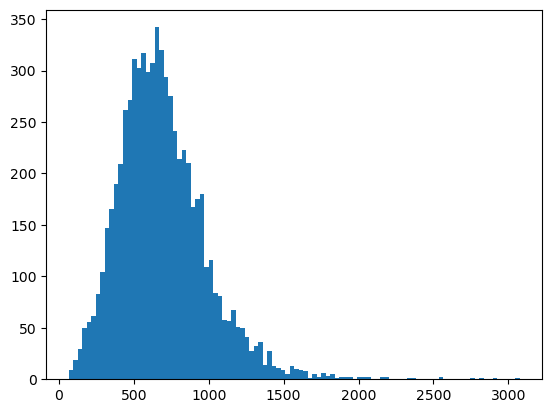

In [7]:

import matplotlib.pyplot as plt


plt.hist(ds["length"], bins=100)

In [8]:

import pandas as pd
import plotly.express as px
from collections import Counter


group = []
labels = []

group_thresholds = [0, 50, 100, 200, 500, 1000, 2000, 10000]

for sample_labels in ds["provided_labels"]:
    for i, label in enumerate(sample_labels):
        if label != "O":
            for j in range(1, len(group_thresholds)):
                lower = group_thresholds[j-1]
                upper = group_thresholds[j]
                
                if lower <= i < upper:
                    group.append(f"{lower}-{upper}")
                    labels.append(label)
                    break

pairs = list(zip(labels, group))

counts = Counter(pairs)


data = {
    "label": [],
    "count": [],
    "range": [],
}

for (label, range_), count in counts.items():
    data["label"].append(label)
    data["range"].append(range_)
    data["count"].append(count)

            
df = pd.DataFrame(data)


px.scatter(df, x="range", y="count", color="label", log_y=True, height=1000)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'label=B-NAME_STUDENT<br>range=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'B-NAME_STUDENT',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'B-NAME_STUDENT',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['0-50', '200-500', '500-1000', '1000-2000', '50-100', '100-200',
                          '2000-10000'], dtype=object),
              'xaxis': 'x',
              'y': array([793, 163, 283,  57,  31,  33,   5], dtype=int64),
              'yaxis': 'y'},
             {'hovertemplate': 'label=I-NAME_STUDENT<br>range=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'I-NAME_STUDENT',
              'marker': {'color': '#EF553B', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'I-NAME_STUDENT',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['0-50', '200-500', '500-1000', '1000-2000', '50-100', '100-200',
                          '2000-10000'], dtype=object),
              'xaxis': 'x',
              'y': array([752,  86, 190,  41,  16,   6,   5], dtype=int64),
              'yaxis': 'y'},
             {'hovertemplate': 'label=B-URL_PERSONAL<br>range=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'B-URL_PERSONAL',
              'marker': {'color': '#00cc96', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'B-URL_PERSONAL',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['500-1000', '0-50', '200-500', '1000-2000', '50-100', '2000-10000',
                          '100-200'], dtype=object),
              'xaxis': 'x',
              'y': array([32, 15, 31, 15, 10,  1,  6], dtype=int64),
              'yaxis': 'y'},
             {'hovertemplate': 'label=B-EMAIL<br>range=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'B-EMAIL',
              'marker': {'color': '#ab63fa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'B-EMAIL',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['0-50', '50-100', '500-1000', '200-500'], dtype=object),
              'xaxis': 'x',
              'y': array([21,  3,  6,  9], dtype=int64),
              'yaxis': 'y'},
             {'hovertemplate': 'label=B-ID_NUM<br>range=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'B-ID_NUM',
              'marker': {'color': '#FFA15A', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'B-ID_NUM',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['0-50', '50-100', '500-1000', '200-500', '100-200'], dtype=object),
              'xaxis': 'x',
              'y': array([37, 10, 12, 17,  2], dtype=int64),
              'yaxis': 'y'},
             {'hovertemplate': 'label=I-URL_PERSONAL<br>range=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'I-URL_PERSONAL',
              'marker': {'color': '#19d3f3', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'I-URL_PERSONAL',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['0-50'], dtype=object),
              'xaxis': 'x',
              'y': array([1], dtype=int64),
              'yaxis': 'y'},
             {'hovertemplate': 'label=B-USERNAME<br>range=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'B-USERNAME',
              'marker': {'color': '#FF6692', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'B-USERNAME',
              'orientation': 'v',
              'showle